In [1]:
import MockMaps as MM
import matplotlib.pyplot as plt
import numpy as np
import CalculatePS as CPS
import image_filtering as imf
import MultiGaussBias as MGB
from astropy.io import fits
from astropy.wcs import WCS
import glob
from scipy.optimize import curve_fit
import pandas as pd

In [2]:
MIDASdir   = "/media/charles/Elements/Data/MUSTANG-2/MaDCoWS/MOO_1142/MIDAS_maps_per_scan/PCA5maps/"
MIDASfiles = glob.glob(MIDASdir+"Kelvin*_s0??_map_iter1.fits")

In [3]:
def parse_session_scan(string):

    FileSplt   = string.split('/')
    FileName   = FileSplt[-1]
    NameSplit  = FileName.split('_')
    ProjSemester = NameSplit[10]
    ProjNumber = NameSplit[11]
    SessionNumber = NameSplit[12]
    ScanString = NameSplit[13]
    ProjSem = ProjSemester.split('G')
    FullSession = "_".join(["AG"+ProjSem[1],ProjNumber,SessionNumber])
    ScanSplit = ScanString.split('s')
    #print(ScanSplit)
    ScanNumber = int(ScanSplit[1])

    return FullSession,ScanNumber

def prepare_maps(hdu,fwhm=10.0):

    """
    Purpose:
      This function takes the input maps (a data map and weight map), renormalizes the data map and calculates a mask.
      The renormalization accounts for how the noise is non-uniform (i.e. it increases radially). The mask tries to
      find a good region within which the map has complete coverage (no gaps/holes).

    """

    image = hdu[0].data
    weights = hdu[1].data
    rms = np.ones(weights.shape)
    gi = (weights > 0)
    rms[gi] = np.sqrt(1.0/weights[gi])
    RescaledImage = image/rms
    hdr = hdu[0].header
    Integration = hdr["INTGTIME"]
    TotalWeight = np.sum(weights)
    wcs_inp = WCS(hdu[0].header)
    pixsize = np.sqrt(np.abs(np.linalg.det(wcs_inp.pixel_scale_matrix))) * 3600.0 # in arcseconds
    pixfwhm = fwhm/pixsize       # FWHM in pixels
    smWts = imf.fourier_filtering_2d(weights,"gauss",pixfwhm)     # in Compton y
    MaxWts = np.max(smWts)
    GoodWts = (smWts > 0.1*MaxWts)
    Mask = np.zeros(image.shape)
    Mask[GoodWts] = 1

    return RescaledImage, Mask,pixsize

def ax_zoom(zoom,ax):
    """
    For a given axes object (with an image), zoom in.

    Parameters
    ----------
    zoom : float
       A factor by which you wish to zoom in (zoom > 1).
    ax : class:`matplotlib.pyplot.axes`
       The axes object with the image.
    """
    ax_x = ax.get_xlim()
    ax_y = ax.get_ylim()
    dx   = (ax_x[1] - ax_x[0])/2
    dy   = (ax_y[1] - ax_y[0])/2
    newd = (1.0 - 1.0/zoom)
    newx = [ax_x[0]+newd*dx,ax_x[1]-newd*dx]
    newy = [ax_y[0]+newd*dy,ax_y[1]-newd*dy]
    ax.set_xlim(newx)
    ax.set_ylim(newy)


In [4]:
def pink(x,p0,p1,a1):

    y = p1*(x**-a1) + p0

    return y

def fit_pink(k_in,p_in):

    gi = np.isfinite(p_in)
    k = k_in[gi]
    p = p_in[gi]
    #print(p_in.shape,p.shape)
    #print(p_in)
    p0_guess = np.min(p)
    maxP = np.max(p)
    maxK = k[p == maxP]
    a1_guess = 2
    p1_guess = np.max(p) * maxK**a1_guess
    #print(p0_guess,a1_guess,p1_guess)
    init_pars = np.array([p0_guess,p1_guess.item(0),a1_guess])
    #print(init_pars.shape)
    #import pdb;pdb.set_trace()
    sigma = np.sqrt(p)/3.0
    
    popt,pcov = curve_fit(pink,k,p,p0=init_pars,sigma=sigma)

    return popt,pcov

def pink_metric(k_in,p_in,popt):

    pWhite = [popt[0],0,0]
    pRed = [0,popt[1],popt[2]]
    white = pink(k_in,*pWhite)
    red = pink(k_in,*pRed)
    pInk = pink(k_in,*popt)
    sqInk = 3*(pInk - p_in)**2/p_in
    ReducedChi = np.mean(sqInk)

    kRed = (k_in[-1]**(2 - popt[2]) - k_in[0]**(2 - popt[2]))
    vRed = 2*np.pi*popt[1]*kRed/(2 - popt[2])

    kWhite = (k_in[-1]**2 - k_in[0]**2)
    vWhite = np.pi*popt[0]*kWhite

    vRatio = vRed/vWhite

    k_eq = (popt[0]/popt[1])**(-1/popt[2])
    #print("Equal point: ",k_eq)
    kRedEq = (k_eq**(2 - popt[2]) - k_in[0]**(2 - popt[2]))
    vRedEq = 2*np.pi*popt[1]*kRedEq/(2 - popt[2])

    kWhiteEq = (k_eq**2 - k_in[0]**2)
    vWhiteEq = np.pi*popt[0]*kWhiteEq
    
    EqRatio = vRedEq/vWhiteEq  # This should necessarily be > 1

    ##########################################################

    return ReducedChi,vRatio,EqRatio,red,white,k_eq
    

/home/charles/Python/ForGitHub/EZ2use_SBF/CalculatePS.py:184: RuntimeWarning: divide by zero encountered in scalar divide
  S2_kr      = (N/M) * np.mean(Df**2) #  notwithstanding above comment:
/home/charles/Python/ForGitHub/EZ2use_SBF/CalculatePS.py:184: RuntimeWarning: invalid value encountered in scalar multiply
  S2_kr      = (N/M) * np.mean(Df**2) #  notwithstanding above comment:
/tmp/ipykernel_363626/1087238443.py:47: RuntimeWarning: invalid value encountered in scalar power
  k_eq = (popt[0]/popt[1])**(-1/popt[2])


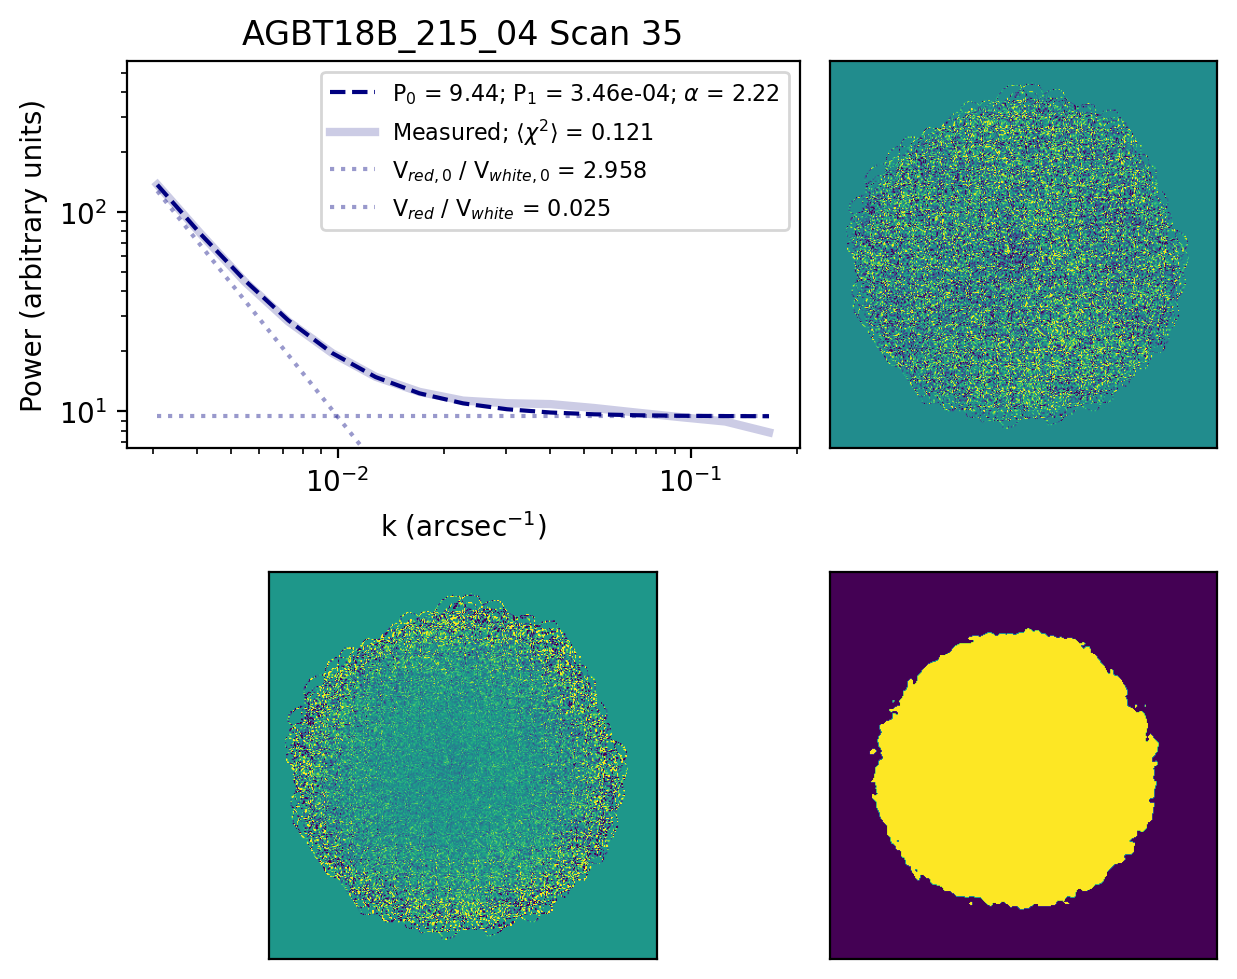

In [5]:
a12Fig = plt.figure(1,figsize=(7,5),dpi=200)
myfs = 8

Sessions = []
Scans = []
Chis = []
RatiosFull = []
RatiosKnee = []
Knees = []
WNlvl = []
RedNorms = []
Slopes = []

for MIDASfile in MIDASfiles:

    Session,Scan = parse_session_scan(MIDASfile)
    hdu = fits.open(MIDASfile)
    img,msk,pxsz = prepare_maps(hdu)
    nx,ny = img.shape
    center = [nx//2,ny//2]
    annular_width = nx/1.4
    nRings = int(np.round(nx*1.4*pxsz/(2*annular_width)))
    rings = (np.arange(nRings+1) ) * annular_width 
    colors = plt.cm.jet(np.linspace(0,1,nRings))

    kmax = 1.0 / (3*pxsz) # Good to have a buffer. There's a limit to how high one can accurately recover the power
    kmin = 2.0 / nx
    nkbins = 15
    kbin, MH_pk, MH_S2k, MH_Ak, MH_err = CPS.MaskRings(img, center, rings, pxsz,kmax=kmax,kmin=kmin,nkbins=nkbins,
                                                   addmask=msk)
    a12Fig.clf()
    a12Ax = a12Fig.add_subplot(221)
    for ri in range(nRings-1):
        #print(ri,nRings)
        popt,pcov = fit_pink(kbin,MH_pk[:,ri])
        ymin = np.min(MH_pk[:,ri])
        ymax = np.max(MH_pk[:,ri])
        a12Ax.set_ylim([ymin/1.2,ymax*np.sqrt(ymax/ymin)])
        pmodel = pink(kbin,*popt)
        parNames = [r"P$_0$",r"P$_1$",r"$\alpha$"]
        parStrings = [pN+" = {:.2f}".format(pV) if pi != 1 else pN+" = {:.2e}".format(pV) for pi,(pN,pV) in enumerate(zip(parNames,popt))]
        myLabel = "; ".join(parStrings)
        a12Ax.plot(kbin,pmodel,"--",color=colors[ri],label=myLabel)
        ReducedChi,vRatio,EqRatio,red,white,knee = pink_metric(kbin,MH_pk[:,ri],popt)
        MeasLabel = "Measured; "+r"$\langle {\chi^2} \rangle$ = " + "{:.3f}".format(ReducedChi)
        a12Ax.plot(kbin,MH_pk[:,ri],color=colors[ri],alpha=0.2,lw=3,label=MeasLabel)
        a12Ax.plot(kbin,white,":",color=colors[ri],alpha=0.4,label=r"V$_{red,0}$ / V$_{white,0}$ = "+"{:.3f}".format(EqRatio))
        a12Ax.plot(kbin,red,":",color=colors[ri],alpha=0.4,label=r"V$_{red}$ / V$_{white}$ = "+"{:.3f}".format(vRatio))
        ####################################################
        Sessions.append(Session)
        Scans.append(Scan)
        Chis.append(ReducedChi)
        RatiosFull.append(vRatio)
        RatiosKnee.append(EqRatio)
        Knees.append(knee)
        WNlvl.append(popt[0])
        RedNorms.append(popt[1])
        Slopes.append(popt[2])

    #a12Ax.plot(ks,ps)
    a12Ax.set_yscale("log")
    a12Ax.set_xscale("log")
    a12Ax.set_xlabel(r"k (arcsec$^{-1}$)")
    a12Ax.set_ylabel("Power (arbitrary units)")
    a12Ax.set_title(Session+" Scan "+repr(Scan))
    a12Ax.legend(fontsize=myfs)
    #a12Ax.set_xlim([kc/3.0,1.0/pixsize])
    #a12Ax.set_ylim([ymin/5.0,np.max(ps)*5.0])

    imgAx = a12Fig.add_subplot(222)
    imgMax,imgMin = np.max(img),np.min(img)
    imgAx.imshow(img,norm="linear",vmin=imgMin/3,vmax=imgMax/3)
    imageAx = a12Fig.add_subplot(223)
    imageMax,imageMin = np.max(hdu[0].data),np.min(hdu[0].data)
    imageAx.imshow(hdu[0].data,norm="linear",vmin=imageMin/10,vmax=imageMax/10)
    maskAx = a12Fig.add_subplot(224)
    maskAx.imshow(msk)
    imgAx.tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False)
    imageAx.tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False)
    maskAx.tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False)
    ax_zoom(1.8,imgAx)
    ax_zoom(1.8,imageAx)
    ax_zoom(1.8,maskAx)
    
    a12Fig.tight_layout()
    filename = Session+"_Scan_"+repr(Scan)+"_metrics_v4.png"
    a12Fig.savefig(MIDASdir+filename)
    #import pdb;pdb.set_trace()


ScanMetrics = {"Session":Sessions,"Scan":Scans,"Chis":Chis,"RatiosFull":RatiosFull,"RatiosKnee":RatiosKnee,
               "Knees":Knees,"WNlvl":WNlvl,"RedNorms":RedNorms,"Slopes":Slopes}
df = pd.DataFrame(ScanMetrics)
df.to_excel(MIDASdir+"ScanMetrics_v4.xlsx",index=False,sheet_name="MIDAS_maps")
    